In [1]:
%run config_check.py

You are currently using this configuration -
Python:  3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]
Numpy:  1.14.0
Scipy:  1.0.0
Matplotlib:  2.1.2
Pystan:  2.17.1.0
ipywidgets:  7.2.1

The code was tested on Python:  3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) [GCC 7.2.0], Numpy:  1.14.0, Scipy:  1.0.0, Matplotlib:  2.1.2, Pystan:  2.17.1.0, ipywidgets:  7.1.1


In [2]:
# <api>
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from matplotlib import pyplot as plt
%matplotlib inline

# Load classes and functions from the previous parts
from jupyter_cms.loader import load_notebook
smpl1 = load_notebook('./Sampling_part1.ipynb')
smpl2 = load_notebook('./Sampling_part2.ipynb')
smpl3 = load_notebook('./Sampling_part3.ipynb')
smpl4 = load_notebook('./Sampling_part4.ipynb')

# Sampling methods

### Slice Sampling

Slice sampling is an example of an auxiliary variable method. In this case, the state space is enlarged to $x, u$ and sampling from a target distribution $p(x,u)$ instead. To obtain samples from $p(x)$ the $u$-component can simpy be dropped as
$$ \mathbb{E}_p[f] = \int f(x) p(x) dx = \int \int f(x) p(x,u) dx du \approx \frac{1}{N} \sum_{i=1}^N f(x_i) $$

Slice sampling aims to sample uniformly from the region below $p(x)$, i.e. $p(x,u) = Uniform(\{x,u: 0 < u < p(x)\})$. It does this by interleaving two Gibbs steps:

1. Sample $u \sim p(u|x) = Uniform(0, p(x))$
2. Sample $x \sim p(x|u) = Uniform(\{x : u < p(x)\})$

The second step requires a method to sample uniformly from the so called *slice*, i.e. the set of all $x$ with probability at least $u$. In high-dimensional spaces this is often infeasible and slice sampling is usually formulated for a 1-dimensional $x$. In this case, the slice can be obtain by an adaptive procedure which expands and shrinks a range around the current sample. In this sense, slice sampling can be considered as a Metropolis-Hastings sampling which adapts its proposal distribution to the width of the probable region.

**Exercise:** Show that the slice adjustment in the algorithm below leaves the uniform target density invariant.

In [3]:
# <api>
class SliceSampling (smpl1.Sampling):
    def __init__ (self, log_p, x, w):
        self.log_p = log_p
        self.x = x
        self.w = w
        self.samples = 0
        self.evals = 0
        
    def _log_p (self, x):
        self.evals += 1
        return self.log_p(x)
    
    def sample (self):
        self.samples += 1
        # Slice sampling as in MacKay pp. 375
        log_px = self._log_p(self.x)
        log_u_prime = np.log(np.random.uniform(low=0, high=np.exp(log_px)))
        # Create interval
        r = np.random.uniform()
        xl = self.x - r*self.w
        xr = self.x + (1-r)*self.w
        while (self._log_p(xl) > log_u_prime): 
            xl -= self.w
        while (self._log_p(xr) > log_u_prime):
            xr += self.w
        # Main sampling loop
        while True:
            x_prime = np.random.uniform(low=xl, high=xr)
            log_px_prime = self._log_p(x_prime)
            if log_px_prime > log_u_prime:
                self.x = x_prime
                return x_prime # Found new sample
            else:
                # Adjust interval
                if x_prime > self.x:
                    xr = x_prime
                else:
                    xl = x_prime
        
    def __str__ (self):
        return "Slice sampling: %d evaluations for %d samples" % (self.evals, self.samples)

In [4]:
sampling = SliceSampling(log_p=lambda x: np.log(smpl2.p(x)), x=-3.0, w=1.5)

smpl1.show_sampling(sampling, plotter=smpl1.gauss_hist, N=1000)
print(sampling)

Output()

Slice sampling: 6621 evaluations for 1000 samples


Slice sampling can be applied to multivariate distributions by sampling in different 1-dimensional directions. Most often the directions are just chosen as the coordinate axis and, similar to Gibbs sampling, all coordinates are sampled in sequence.

Here, we apply this scheme to the 2-dimensional Gaussian example:

In [5]:
# <api>
class MultiSampling (smpl1.Sampling):
    """
    Class that wraps a one-dimensional sampler and applies it to 
    a sequence of given directions to produce a new sample
    """
    def __init__(self, uni_sampler, log_p, x, directions):
        """
        uni_sampler is called with a log_p function and current sample x.
        It needs to return a valid sampler which is then asked to draw a sample.
        """
        self.uni_sampler = uni_sampler
        self.log_p = log_p
        self.x = x
        self.directions = directions
        
    def sample (self):
        # Loop through directions
        for d in self.directions:
            uni_log_p = lambda ux: self.log_p(self.x + ux*d)
            ux_prime = self.uni_sampler(uni_log_p, 0).sample()
            self.x = self.x + ux_prime*d
        return self.x

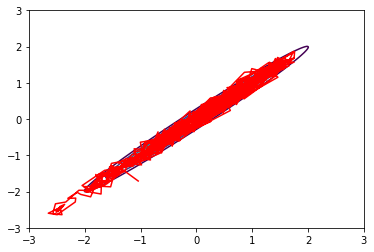

In [6]:
sampling = MultiSampling(lambda log_p, x: SliceSampling(log_p, x, w=1.0), \
                         log_p=smpl2.p2d.logpdf, \
                         x=np.array([1.5,0]), \
                         directions=[np.array([1,0]), np.array([0,1])])
samples = [sampling.sample() for _ in range(1000)]
plt.plot(np.array(samples)[:,0], np.array(samples)[:,1], 'r-')
plt.contour(smpl2.X, smpl2.Y, smpl2.p2d.pdf(smpl2.XY));

By choosing the sampling directions more clever, we can substantially reduce the random walk behavior and improve the efficiency of sampling from the 2-dimensional Gaussian.

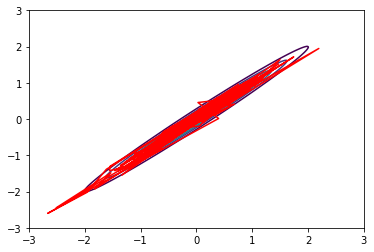

In [7]:
sampling = MultiSampling(lambda log_p, x: SliceSampling(log_p, x, w=1.0), \
                         log_p=smpl2.p2d.logpdf, \
                         x=np.array([1.5,0]), \
                         directions=[np.array([1,1]), np.array([1,-1])])
samples = [sampling.sample() for _ in range(100)]
plt.plot(np.array(samples)[:,0], np.array(samples)[:,1], 'r-')
plt.contour(smpl2.X, smpl2.Y, smpl2.p2d.pdf(smpl2.XY));

### Hamiltonian Monte Carlo (HMC)

HMC uses gradient information to automatically find suitable directions. In this sense it fixes the above shortcoming that we have to specify a suitable proposal distribution in Metropolis-Hastings or adapted directions in multi-variate slice sampling. HMC makes clever use of a physical analogy and augments the state space with an auxiliary momentum vector $\mathbf{p}$.

Write the probability density $p(x)$ as
$$ p(x) = \frac{1}{Z} e^{-E(x)} $$
and assume that the *energy* $E(x)$ as well as its gradient with respect to $x$ can be evaluated. Note that any $p(x)$ can be written in the above form by choosing $E(x) = - \log p(x)$.

Now, define the Hamiltonian $H(x) = E(x) + K(\mathbf{p})$, i.e. the total (potential $E(x)$ plus kinetic $K(\mathbf{p}) = \frac{1}{2} \mathbf{p}^t \mathbf{p}$) energy of the system. It is well known from physics that the following dynamics conserves energy
$$ \begin{array}{lcl} \dot{x} & = & \mathbf{p} \\ \dot{\mathbf{p}} & = & - \frac{\partial}{\partial x} E(x) \end{array} $$

Thus, we can sample from the joint density $p(x,\mathbf{p}) \propto e^{E(x)} e^{K(\mathbf{p})}$ using Gibbs-like steps:

1. Sample $\mathbf{p} \sim p(\mathbf{p}|x) = \mathcal{N}(0, \mathbb{1})$
2. Produce new state $x'$ by simulating the Hamiltonian dynamics for some time. Due to energy conservation the proposed $x'$ will always be accepted.

Also volume is preserved by the Hamiltonian dynamics. This simplifies the algorithm considerably as no Jacobian adjustment is necessary to account for the change in volume.

In [8]:
# <api>
def integrate_H(xp, dE_dx, T, dt, method='euler'):
    """
    Integrate the state xp for some time with the Hamiltonian H(x) = E(x) + K(x) 
    """
    x,p = xp
    t = 0
    while (t < T):
        t += dt
        if method=='euler':
            gradE = dE_dx(x)
            x += p*dt
            p += - gradE*dt
        else:
            error('Unknown integratin method')
    return x,p

Unfortunately, Euler integration is very unstable for the Hamiltonian dynamics. Further, to ensure detailed balance we need to make sure that the integration scheme is reversible. In practice, a leap-frog integration is applied where half steps to the momentum are interleaved with an update to the state. In addition, leap-frog integration leads to a deterministic, discrete dynamics that is exactly invertible and preserves volume (as each update changes one variable based on the state of the other variable only, i.e. it is a simple shift in each variable).

In [9]:
# <api>
def integrate_H(xp, dE_dx, T, dt, method='leap_frog'):
    """
    Integrate the state xp for some time with the Hamiltonian H(x) = E(x) + K(x) 
    """
    x,p = np.copy(xp)
    t = 0
    while (t < T):
        t += dt
        if method=='euler':
            gradE = dE_dx(x)
            x += p*dt
            p += - gradE*dt
        elif method=='leap_frog':
            p += - dE_dx(x)*dt/2
            x += p*dt
            p += - dE_dx(x)*dt/2
        else:
            error('Unknown integratin method')
    return x,p

Demonstration on the 2-dimensional Gaussian example:

In [10]:
# <api>
# Simple numeric differentiation
def grad (f, x):
    eps = 1e-4
    gradx = np.zeros_like(x)
    for i in range(x.size):
        dx = np.zeros_like(x)
        dx[i] = 1
        gradx[i] = (f(x + dx*eps/2) - f(x - dx*eps/2))/eps
    return gradx

def dE2d_dx(x):
    return grad(lambda x: - smpl2.p2d.logpdf(x), x)

x0 = np.array([1.5, 0]); p0 = np.array([0.1, -0.1])
traj_euler = [(x0,p0)]; traj_leap_frog = [(x0,p0)]
dt = 0.01
for i in range(250):
    traj_euler.append(integrate_H(traj_euler[-1], dE2d_dx, dt, dt, 'euler'))
    traj_leap_frog.append(integrate_H(traj_leap_frog[-1], dE2d_dx, dt, dt, 'leap_frog'))
traj_euler = np.array(traj_euler).squeeze(); traj_leap_frog = np.array(traj_leap_frog).squeeze()

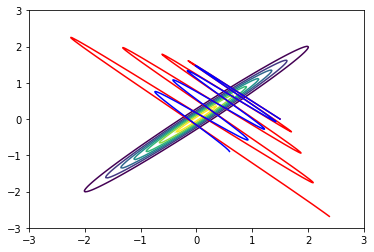

In [11]:
plt.contour(smpl2.X, smpl2.Y, smpl2.p2d.pdf(smpl2.XY));
plt.plot(traj_euler[:,0,0], traj_euler[:,0,1], 'r-')
plt.plot(traj_leap_frog[:,0,0], traj_leap_frog[:,0,1], 'b-');
plt.axis([-3,3,-3,3]);

In practice, also the leap frog integration is not perfect and energy is not precisely conserved. Thus, the actual algorithm includes a Metropolis step which discards samples with lower energy to ensure that it samples from the correct distribution.

In [12]:
# <api>
class HMC (smpl1.Sampling):
    def __init__(self, x, E, dE_dx=None, Tau=42, dtau=0.04):
        self.x = x
        self.E = E
        if dE_dx is None:
            dE_dx = lambda x: grad(E, x)
        self.dE_dx = dE_dx
        self.Tau = Tau
        self.dtau = dtau
        
    def _H (self, x, p):
        return self.E(x) + 0.5*np.dot(p.T, p)
        
    def sample (self):
        # Gibbs step for momentum
        x = self.x
        p = np.random.normal(size=x.shape)
        H = self._H(x, p)
        
        # Simulate dynamics
        xnew, pnew = integrate_H((x,p), self.dE_dx, self.Tau*self.dtau, self.dtau, 'leap_frog')
        Hnew = self._H(xnew, pnew)
        
        # Metropolis step
        if np.log(np.random.uniform()) < H - Hnew: # Remember: H = - logp
            self.x = xnew
        return self.x

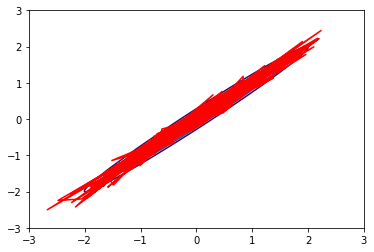

In [13]:
sampling = HMC(np.array([1.5,0]), lambda x: - smpl2.p2d.logpdf(x))

samples = [sampling.sample() for _ in range(250)]
plt.plot(np.array(samples)[:,0], np.array(samples)[:,1], 'r-')
plt.contour(smpl2.X, smpl2.Y, smpl2.p2d.pdf(smpl2.XY));